# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [886]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [887]:
config_file = 'config/config_commodities_2015_2019.json'

### Import Configurations

In [888]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [889]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [890]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [891]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [892]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (config['dataset']['training_initial_date'],
                                                             config['dataset']['training_final_date']),
                                                            (config['dataset']['testing_initial_date'],
                                                             config['dataset']['testing_final_date']),
                                                            remove_nan=True)

Total of 208 tickers
Total of 142 tickers after removing tickers with Nan values


In [893]:
len(df_prices_train)+len(df_prices_test)

1006

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [894]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,AMJ,AMLP,AMU,AMZA,ATMP,BCM,BNO,BOIL,CANE,...,VDE,WEAT,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
2015-01-05,0.053097,-0.045396,-0.027180,-0.045270,-0.055009,-0.040658,-0.012258,-0.059941,-0.018727,-0.012071,...,-0.039668,0.008772,-0.048523,-0.041368,-0.036929,-0.064116,-0.025797,-0.032382,-0.031305,-0.047797
2015-01-06,0.040534,-0.020094,-0.013388,-0.017339,-0.027492,-0.016145,0.000380,-0.037681,0.001908,0.035799,...,-0.015038,0.006324,-0.031412,-0.014690,-0.013791,-0.030276,-0.013481,-0.007968,-0.016611,-0.040389
2015-01-07,0.000713,0.000911,-0.003540,-0.002161,-0.011112,-0.008547,-0.006456,0.002510,-0.036190,-0.012648,...,0.002450,-0.019945,-0.009920,0.002130,0.004434,-0.010027,-0.005368,-0.009639,-0.005835,-0.000650
2015-01-08,-0.028246,0.012975,0.008881,0.011909,0.013648,0.012762,0.001379,0.002003,0.047431,0.030743,...,0.021623,-0.019726,0.016570,0.022450,0.009508,0.033840,0.009814,0.022709,0.016991,0.027334
2015-01-09,0.017587,-0.002921,0.000587,-0.000357,0.002554,0.001158,0.000000,-0.017491,0.011950,-0.009114,...,-0.006994,-0.007359,-0.014026,-0.007925,-0.002355,0.007793,0.001458,0.000000,0.002126,-0.016561


In [895]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  10011.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [896]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[0.04398733 0.02581234 0.0142298  0.00389465 0.0026783  0.00221295
 0.00162234 0.00118351 0.00106284 0.00072024 0.00066342 0.00062216
 0.00056482 0.00048364 0.0003776  0.00035537 0.0003045  0.00029783
 0.00027415 0.00024786]


In [897]:
N_PRIN_COMPONENTS = 8#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [898]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 18
Pairs to evaluate: 343


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [899]:
print(counts)

1     20
0     12
2      7
4      7
9      4
3      4
16     4
17     4
12     4
5      3
13     3
8      3
10     2
11     2
7      2
6      2
14     2
15     2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [900]:
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  10
Returns shape:  (754, 142)
Clusters discovered: 19
Pairs to evaluate: 248
Silhouette score  0.02703692056007767

Number of components:  11
Returns shape:  (754, 142)
Clusters discovered: 18
Pairs to evaluate: 240
Silhouette score  -0.005684517717047354

Number of components:  12
Returns shape:  (754, 142)
Clusters discovered: 15
Pairs to evaluate: 137
Silhouette score  -0.06759202416862789

Number of components:  13
Returns shape:  (754, 142)
Clusters discovered: 13
Pairs to evaluate: 90
Silhouette score  -0.125671740068444

Number of components:  14
Returns shape:  (754, 142)
Clusters discovered: 12
Pairs to evaluate: 60
Silhouette score  -0.18060320229575108

Number of components:  15
Returns shape:  (754, 142)
Clusters discovered: 10
Pairs to evaluate: 42
Silhouette score  -0.23939304187542085

Number of components:  16
Returns shape:  (754, 142)
Clusters discovered: 10
Pairs to evaluate: 37
Silhouette score  -0.24214206054647378

Number of components:  17

**Fundamental analysis for clusters**

In [901]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [902]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker            Segment
145    AMJ  Equity: U.S. MLPs
143   AMLP  Equity: U.S. MLPs
160    AMU  Equity: U.S. MLPs
156   ATMP  Equity: U.S. MLPs
183   IMLP  Equity: U.S. MLPs
150   MLPA  Equity: U.S. MLPs
148   MLPI  Equity: U.S. MLPs
194   YMLI  Equity: U.S. MLPs

Cluster 1:
    Ticker                            Segment
69     BCM          Commodities: Broad Market
2     CORN      Commodities: Agriculture Corn
0      DBA           Commodities: Agriculture
26     DBC          Commodities: Broad Market
77    DJCI          Commodities: Broad Market
30     DJP          Commodities: Broad Market
47    FTGC          Commodities: Broad Market
13     FUD           Commodities: Agriculture
53     GCC          Commodities: Broad Market
17     GRU    Commodities: Agriculture Grains
18     RJA           Commodities: Agriculture
134    RJI          Commodities: Broad Market
5     SOYB  Commodities: Agriculture Soybeans
15    TAGS           Commodities: Agriculture
14     UAG      

**Visualizing with t-sne**

In [903]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

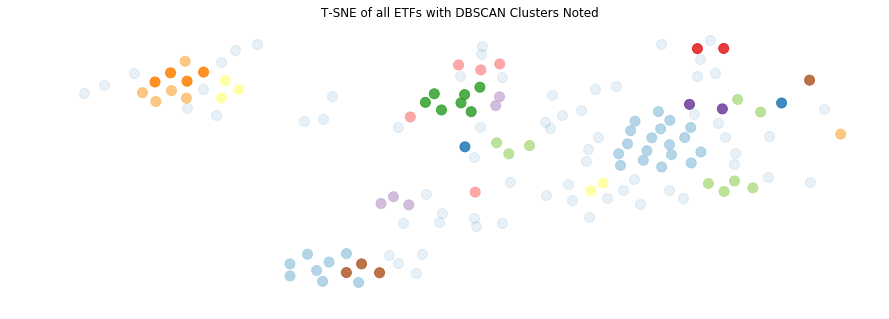

In [904]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

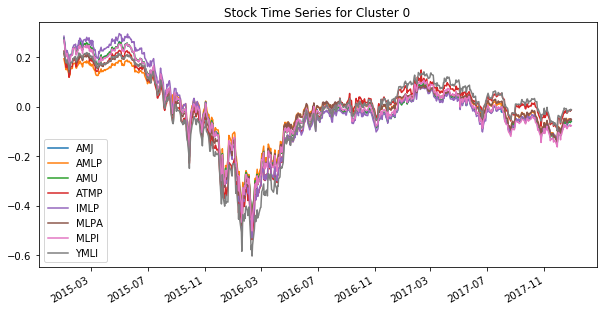

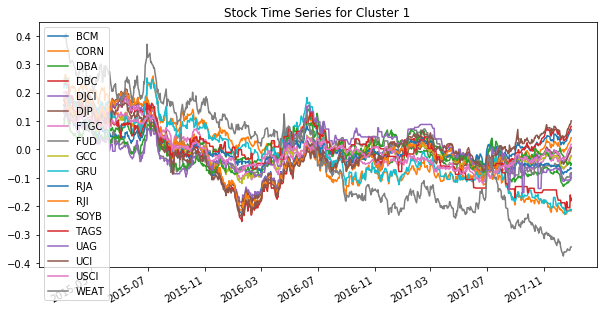

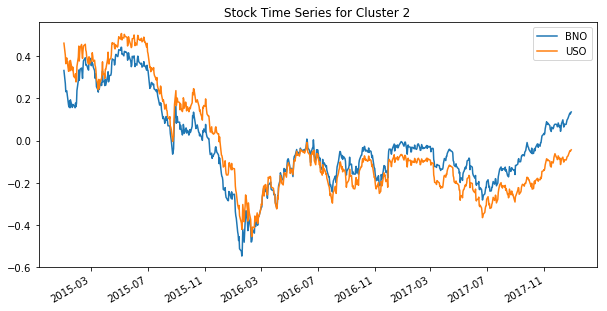

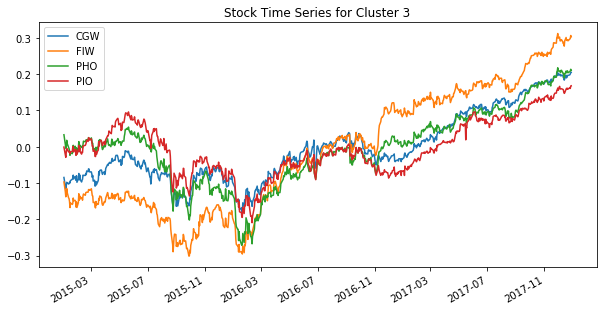

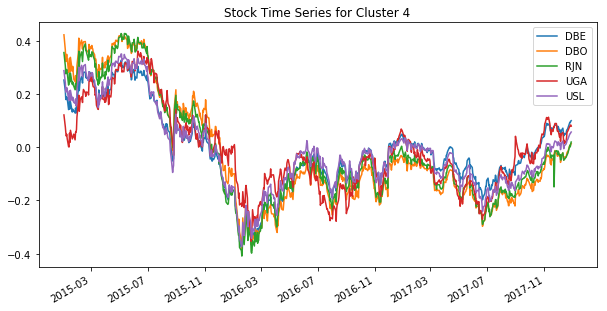

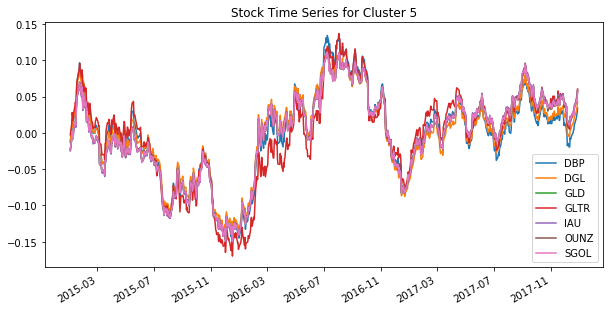

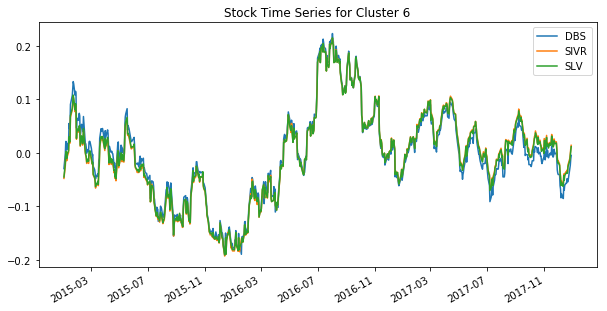

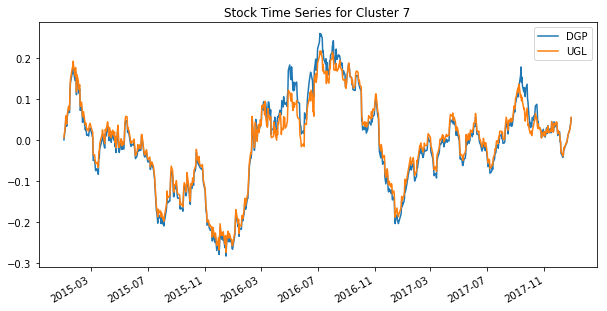

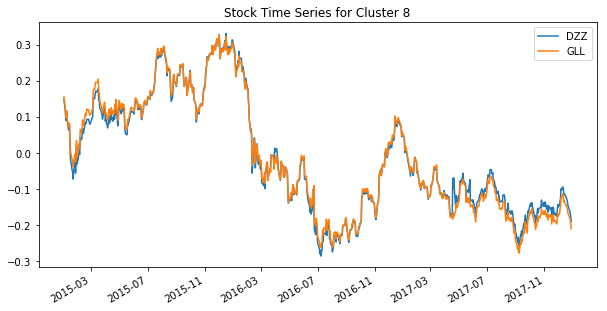

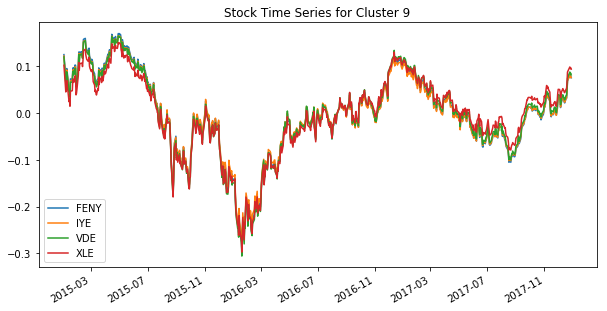

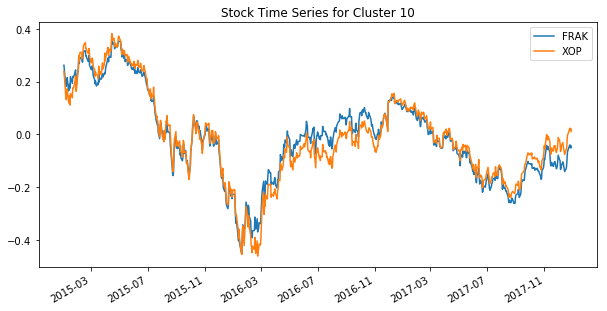

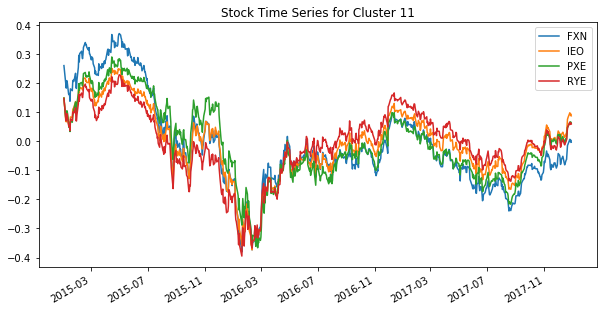

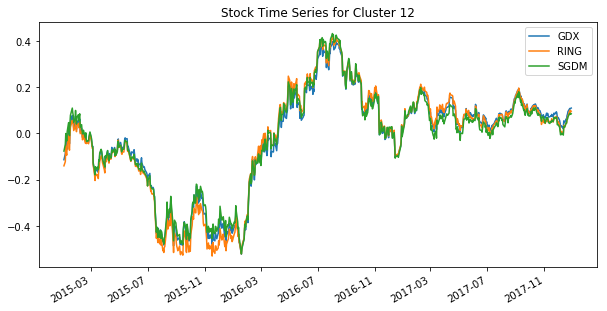

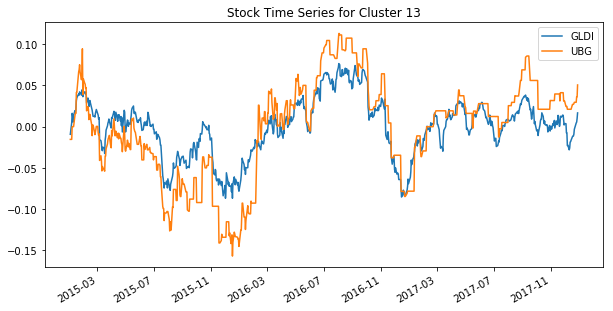

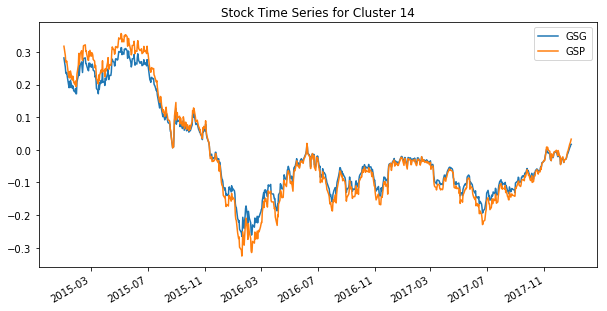

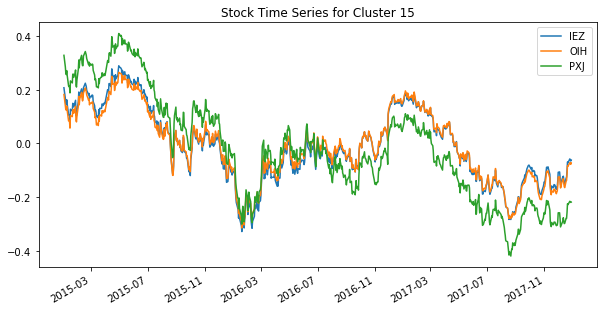

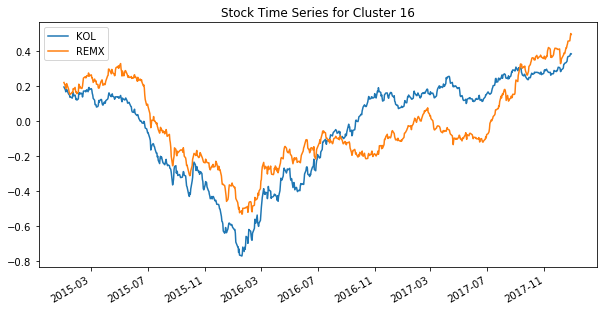

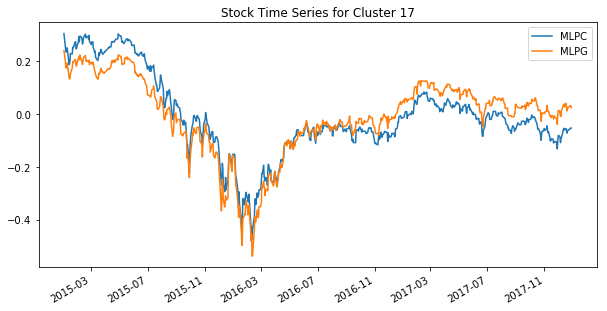

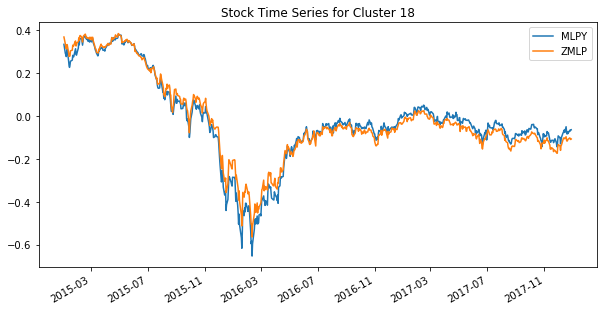

In [905]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [906]:
pairs, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 48 pairs
The pairs contain 35 unique tickers


In [907]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [908]:
n_years_train = round(len(df_prices_train)/240)

**Applying Bollinger Bands**

In [909]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter,
                                                                                         test_mode=False
                                                                                         )

**Bollinger Bands Performance**

In [910]:
avg_sharpe_bollinger, total_roi_bollinger, anual_roi_bollinger, positive_pct_bollinger = \
    trader.calculate_metrics(sharpe_results_bollinger, cum_returns_bollinger, n_years_train)

Average result:  0.9222547176695254
avg_total_roi:  15.833636353141449
avg_annual_roi:  5.021503185776788
91.66666666666667 % of the pairs had positive returns


**Applying the Kalman filter based strategy**

In [911]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)

In [912]:
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  2.2719856036664896
avg_total_roi:  36.67029225541244
avg_annual_roi:  10.974886035850329
85.41666666666667 % of the pairs had positive returns


Sharpe Ratio Distribution: 


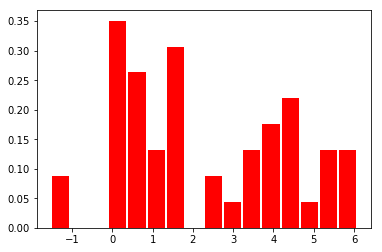

In [913]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [914]:
n_years_test = round(len(df_prices_test)/240)

### Approach 1: Keeping every pair

**Bollinger Bands Out-of-Sample**

In [915]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )

In [916]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.08079766596590164
avg_total_roi:  0.9219128928171477
avg_annual_roi:  0.921912892817156
50.0 % of the pairs had positive returns


**Kalman Out-of-Sample**

In [917]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [918]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
        trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.6379037674876946
avg_total_roi:  9.986892560312953
avg_annual_roi:  9.986892560312954
81.25 % of the pairs had positive returns


### Approach 2: Keeping only pairs that had positive returns in the training period

**Bollinger Strategy**

In [919]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
profitable_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [920]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(profitable_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True)

In [921]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.0714080557305793
avg_total_roi:  0.9284098298039918
avg_annual_roi:  0.928409829804
50.0 % of the pairs had positive returns


**Kalman Strategy**

In [922]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [923]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [924]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.7777807463022957
avg_total_roi:  11.192782512565277
avg_annual_roi:  11.19278251256528
90.2439024390244 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

# Validate the results

The results obtained are suspiciously high. We pretend to look deeper into the numbers.

In [925]:
results, pairs_summary = trader.summarize_results(sharpe_results_kalman_test, cum_returns_kalman_test,
                                                  performance_kalman_test, profitable_pairs)

Average result:  1.7777807463022957
avg_total_roi:  11.192782512565277
avg_annual_roi:  11.19278251256528
90.2439024390244 % of the pairs had positive returns
[ 2 26 23 16 31  9 27 34 36 22  6 14 10 38  5  1  0 28 18  3 21  4 13 29
 37 24 30 15 25  8 40 19 39 17 12 32 20  7 35 33 11]


In [926]:
performance_bollinger_test[4][1][38:]

,pnl,ret,SOYB,BCM,beta,spread,zscore,current_position,position_return_(%)
2018-02-27,0.000000,0.000000,19.0500,29.6632,0.076840,16.770678,NaN,0.0,0.000000
2018-02-28,0.000000,0.000000,19.1200,29.3734,0.146281,14.823242,0.356708,0.0,0.000000
2018-03-01,0.000000,0.000000,19.3100,29.2405,0.156788,14.725452,0.277921,0.0,0.000000
2018-03-02,0.000000,0.000000,19.3300,29.3800,0.168053,14.392615,0.160463,0.0,0.000000
2018-03-05,0.000000,0.000000,19.4500,29.5690,0.360700,8.784471,-0.629574,0.0,0.000000
2018-03-06,-0.000000,0.000000,19.4150,29.7100,0.602700,1.508793,-1.656209,0.0,0.000000
2018-03-07,0.058180,0.001559,19.2500,29.3397,0.729746,-2.160524,-2.133650,1.0,0.000000
2018-03-08,0.063702,0.001567,19.2300,29.2250,0.767659,-3.204837,-2.161876,1.0,0.000000
2018-03-09,-0.483885,-0.011614,18.9150,29.4450,0.690217,-1.408427,-1.783096,1.0,0.000000
2018-03-12,0.143219,0.003650,18.9961,29.3550,0.605613,1.218321,-1.341336,1.0,0.000000


In [927]:
performance_kalman_test[10][1]

,pnl,ret,DBA,TAGS,beta,e,sqrt(Q),current_position,position_return_(%)
Date,,,,,,,,,
2018-01-02,NaN,0.000000,18.770665,22.4700,0.000000,18.770665,0.031623,0.0,0.000000
2018-01-03,0.000000,0.000000,18.760771,22.4700,0.817125,18.760771,0.227146,0.0,0.000000
2018-01-04,0.000000,0.000000,18.731086,22.4700,0.831674,0.333930,0.229294,0.0,0.000000
2018-01-05,0.000000,0.000000,18.632137,22.4700,0.827640,-0.092598,0.229295,0.0,0.000000
2018-01-08,0.000000,0.000000,18.503503,22.4700,0.821958,-0.130395,0.229295,0.0,0.000000
2018-01-09,0.000000,0.000000,18.543082,22.4700,0.823575,0.037100,0.229295,0.0,0.000000
2018-01-10,0.000000,0.000000,18.473818,22.3600,0.824539,0.022034,0.228196,0.0,0.000000
2018-01-11,0.000000,0.000000,18.404553,22.1515,0.829092,0.103075,0.226134,0.0,0.000000
2018-01-12,0.000000,0.000000,18.364974,22.1515,0.827432,-0.037564,0.226173,0.0,0.000000


**Controlling for range of returns**

In [928]:
print('Maximum return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].max())

Maximum return obtained in a single trade, per pair
1.6946123163708693
2.505899170251258
1.4097409016118556
2.1338430897533733
1.6860522784658327
1.0425194102006152
2.054833774069764
0
1.1358655427785358
1.5474263527007093
4.837041157433486
1.2087901387847655
1.2996098044427695
2.0149815929791703
3.646007819933672
1.4869208113964971
1.763316563992845
2.059772822376038
1.806935696337253
1.5431466122493243
1.0767028815507729
1.9846759279724235
1.98345263450177
4.963191236212139
1.9120529726824431
1.127969296244724
1.339603219609664
2.466229846863466
2.2900974202672675
5.100732310556388
1.5912214006452041
5.285311934951409
1.698734733560392
1.0254646600236894
1.7750529197507303
0
1.574602557150273
0.4523774652568813
0.9283107797022572
0.5567364222407445
0.19828507758714586


In [929]:
print('Worst return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].min())

Worst return obtained in a single trade, per pair
0.0
-0.03898631743475267
-0.8666528259521855
-0.5557883936601171
-1.5394115691793275
-0.7605602357658614
-2.111547984444484
0
-1.7127939561846994
-1.8756780715404653
-1.0718682047711092
-1.9666305612602963
-1.70524894202696
-2.4449091481068774
-1.1270335889943972
-0.5939794891703931
-2.5292814922177276
-1.1060010727740544
-1.3679391044775002
-1.09435987833435
-1.716908630159475
-1.9214497234602668
-1.7707414349692474
-0.3706235624404641
-2.894272781633167
-1.6085203662937309
-0.517282180567491
-1.3941386926228039
-1.4131012872760862
0.0
-3.3149641040919997
-1.9627068995084485
-3.217342722452321
-1.509843199222216
-4.049489483001212
0
-1.9388865168872838
-0.5009205463778588
0.0
-0.8099995090938727
0.0


Tanto as returns máximas como as mínimas parecem ter valores dentro da normalidade.

## Training vs Validation

For a far comparison, we should compare the test resuls with the results obtained in the training set, but also using only the profitable pairs:

In [930]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  2.733475477230469
avg_total_roi:  43.77295172433407
avg_annual_roi:  12.86494207661837
100.0 % of the pairs had positive returns


In [931]:
print('The sharpe ratio obtained in the training set with the pairs used on the test set is ', avg_sharpe_kalman)
print('The sharpe ratio obtained in the test set is ', avg_sharpe_kalman_test)

The sharpe ratio obtained in the training set with the pairs used on the test set is  2.733475477230469
The sharpe ratio obtained in the test set is  1.7777807463022957


As expected, the sharpe ratio is indeed higher in the training set.

In [932]:
len(pairs)

48

In [933]:
len(profitable_pairs)

41

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be interested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [934]:
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

3 of the 48 pairs identified in the training set are also cointegrated in the test set


In [935]:
profitable_pairs_overlapped, profitable_pairs_overlapped_index = series_analyser.pairs_overlap(profitable_pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(profitable_pairs_overlapped), len(profitable_pairs)))

3 of the 41 pairs with positive returns identified in the training set are also cointegrated in the test set


### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration is a very important predictor of future returns.

We also compare the average performance of the two groups two see the relevance of being cointegrated with respect to the sharpe ratio obtained.

*Still cointegrated*

In [936]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])

if len(sharpe_results_pairs_overlapped)>0:
    _,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)
else:
    print('0% of the pairs cointegrated in the train are also cointegrated in the test set')

Average result:  2.0306122805026914
avg_total_roi:  7.959087698875848
avg_annual_roi:  7.959087698875855
100.0 % of the pairs had positive returns


*Not cointegrated anymore*

In [937]:
# distribution for pairs which were cointegrated in train but not in test
profitable_pairs_not_overlapped_index = [i for i in np.arange(0,len(profitable_pairs))\
                                         if i not in profitable_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Average result:  1.7578203620233168
avg_total_roi:  11.448074208382865
avg_annual_roi:  11.448074208382874
89.47368421052632 % of the pairs had positive returns


Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return. Furthermore, we can conclude from the results that being cointegrated implied that those pairs generated higher returns. 

**TO REVIEW:Conclusion**: The fact that a pair is not cointegrated anymore does not impact the results obained. In fact, we just concluded that betting solely on the cointegrated pairs would yield a worse result. Therefore, we should not spend much effort in detecting pairs that are no cointegrated anymore.

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [938]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# APPLY PCA and CLUSTERING
range_n_components = config['PCA']['N_COMPONENTS']
X_test, clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
            series_analyser.clustering_for_optimal_PCA(range_n_components[0], range_n_components[1],
                                                       df_returns_test, config['clustering'])
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            n_clusters=len(counts_test),
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))


Number of components:  10
Returns shape:  (250, 142)
Clusters discovered: 16
Pairs to evaluate: 74
Silhouette score  -0.14819524476406648

Number of components:  11
Returns shape:  (250, 142)
Clusters discovered: 16
Pairs to evaluate: 55
Silhouette score  -0.1918134077190126

Number of components:  12
Returns shape:  (250, 142)
Clusters discovered: 15
Pairs to evaluate: 49
Silhouette score  -0.2211296167108505

Number of components:  13
Returns shape:  (250, 142)
Clusters discovered: 11
Pairs to evaluate: 43
Silhouette score  -0.22215061038170864

Number of components:  14
Returns shape:  (250, 142)
Clusters discovered: 11
Pairs to evaluate: 30
Silhouette score  -0.23085678460495804

The best silhouette coefficient was: -0.14819524476406648 for 10 principal components
Found 11 pairs
The pairs contain 17 unique tickers
1 of the 11 pairs identified in the test set are also cointegrated in the training set


Let's see if the pairs identified in the test period lead indeed to improved results:

In [939]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)

Average result:  0.8646877494674051
avg_total_roi:  1.8082850225898246
avg_annual_roi:  1.8082850225898284
63.63636363636363 % of the pairs had positive returns


The sharpe ratio is higher in this scenatio. Note hoewever, that the annual ROI is not so high as the pairs identified previously. This might be linked with the fact that these pairs did not prove to be cointegrated for a period as long as the other and therefore the pairs might be less stable.

## Analyzing the influence of pairs statistics

It's interesting to analyze whether we could have used extra information from the pairs trading statistic, instead of considering it just as a pass or not pass test. `Law 2017` explore this concept on their paper (htey basically rank pairs according to a trade off between t-statistic and spread deviation from its mean). However, what we see below is that there is no obvious influence of any parameter in the performance of the corresponding pair.

In [940]:
pairs_summary.corr()[['sharpe_result', 'positive_trades_per_pair_pct']].loc[['t_statistic', 'p_value',
                                                                             'zero_cross', 'half_life',
                                                                             'hurst_exponent']]

,sharpe_result,positive_trades_per_pair_pct
t_statistic,0.023366,-0.202260
p_value,-0.012837,-0.260705
zero_cross,0.186646,0.159022
half_life,-0.543717,-0.513089
hurst_exponent,-0.307055,-0.205580


### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

In [54]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

NameError: name 'failed_pairs' is not defined

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [ ]:
sharpe_results_kalman_test = np.asarray(sharpe_results_kalman_test)
negative_pairs_indices = np.argwhere(sharpe_results_kalman_test < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

Let's get some more information on the non-profitable pairs:

In [ ]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

To what clusters do these pairs belong?

In [ ]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

How do the statistics rank?

In [ ]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

In [ ]:
df.half_life.mean()

In [ ]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

# What if we haven't done any clustering?

**All against all** - *comparing against the simplest strategy*

In [201]:
no_cluster_series = pd.Series(0,index = etfs_pricing.columns)
total_pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 273 pairs
The pairs contain 41 unique tickers
Found 273 pairs


Bollinger Bands:

In [203]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_boll_aaa, cum_returns_boll_aaa, performance_boll_aaa = trader.apply_bollinger_strategy(total_pairs_all_a_all,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



ALTY,DBV
APR -0.019690076598853357
Sharpe -0.37666046873915465


ALTY,DIVA
APR -0.025647640984403308
Sharpe -0.6268695474526955


ALTY,FLAT
APR 0.08703113849382382
Sharpe 2.030807685607455


ALTY,FUT
APR -0.00956969317643086
Sharpe -0.24988167683679713


ALTY,MRGR
APR -0.03981804664306354
Sharpe -1.0451248382719696


ALTY,SIZ
APR 0.04559781673716912
Sharpe 0.9427153906928085


ALTY,STPP
APR -0.04367292586973193
Sharpe -0.5331008817168248


ALTY,TVIX
APR 0.15845242756404643
Sharpe 1.115245313399877


ALTY,UVXY
APR 0.1815796270931438
Sharpe 1.2097981203596972


BTAL,DIVY
APR 0.017862582442937258
Sharpe 0.5720161966008018


BTAL,FUT
APR 0.029607195121189145
Sharpe 0.7547881999532214


BTAL,JPHF
APR 0.013638947462838669
Sharpe 0.448227225572819


CHEP,DIVA
APR 0.04564442310806638
Sharpe 0.8075868719931734


CHEP,DIVY
APR 0.023734801604629485
Sharpe 0.8278376545038248


CHEP,FTLS
APR -0.05475313592423159
Sharpe -0.5285461968372713


CHEP,FUT
APR 0.07843386895838855
Sharpe 0.95411644317309

APR 0.00018772807011280257
Sharpe 0.02526143334356859


DIVA,RINF
APR -0.045554115023159425
Sharpe -0.9852954618389087


DIVA,RLY
APR -0.01896471359405061
Sharpe -0.4051598950197042


DIVA,SIZ
APR 0.04684659395991919
Sharpe 0.9843676193258001


DIVA,STPP
APR 0.08510554058169872
Sharpe 1.4779415908917648


DIVA,TVIX
APR 0.04146312860638357
Sharpe 0.5933366926315745


DIVA,UVXY
APR 0.05205618217328323
Sharpe 0.734026628385942


DIVA,VEGA
APR -0.05642056614856672
Sharpe -1.564124480081488


DIVA,VIIX
APR 0.11407931714193853
Sharpe 1.9963207888977776


DIVA,VIXM
APR 0.10549016666101863
Sharpe 1.729224592760924


DIVA,VIXY
APR 0.10904664755240456
Sharpe 1.8996972497442384


DIVA,WTMF
APR 0.044035992860706585
Sharpe 1.149769501876805


DIVA,XVZ
APR 0.05254693458806314
Sharpe 1.122031104003971


DIVA,ZIV
APR -0.08165630755618969
Sharpe -1.4003938728604428


DIVY,DYB
APR -0.024569195016881595
Sharpe -0.9748186210390113


DIVY,FMF
APR -0.03682071366157491
Sharpe -1.2561063428888681


DIVY,MNA
A

APR -0.013264208326657423
Sharpe -0.2819939172430328


FUT,GAA
APR 0.03096986960422865
Sharpe 0.9009555733700528


FUT,HTUS
APR 0.02303278694396793
Sharpe 0.7388046003734902


FUT,JPHF
APR 0.04081425011189066
Sharpe 1.572016704331324


FUT,MCRO
APR 0.00807815069318174
Sharpe 0.297958642354598


FUT,MNA
APR -0.0033786845322384407
Sharpe -0.11191925393761408


FUT,MOM
APR 0.04525950443613991
Sharpe 1.2925014335620562


FUT,QAI
APR 0.01793785247566615
Sharpe 0.7177366576557209


FUT,QED
APR -0.05365952144185904
Sharpe -2.052228008273042


FUT,QLS
APR -0.015262384741230317
Sharpe -0.4599074662859895


FUT,QMN
APR 0.007898676507078983
Sharpe 0.33744439145744165


FUT,SIZ
APR -0.011701496822161261
Sharpe -0.27763578578786585


FUT,SVXY
APR -0.008735844000838489
Sharpe -0.18056608916994585


FUT,TVIX
APR -0.03348761812613865
Sharpe -0.701280205107946


FUT,UVXY
APR -0.03202798418065267
Sharpe -0.6713121003841697


FUT,VEGA
APR 0.01130011645109752
Sharpe 0.36898880399202194


FUT,VIIX
APR -0.0

APR -0.028810665304430882
Sharpe -1.2156909622290077


MNA,QMN
APR -0.033148208661512135
Sharpe -1.6304147225551633


MNA,SIZ
APR 0.011458415759262097
Sharpe 0.40091680518302564


MNA,STPP
APR -0.01104767493098513
Sharpe -0.35664442759613796


MNA,TVIX
APR -0.23912276535886245
Sharpe -1.199030258589216


MNA,UVXY
APR -0.28672377462857124
Sharpe -1.5504418831513092


MNA,VEGA
APR -0.024743814592359192
Sharpe -1.0502076686306336


MNA,VIIX
APR 0.03360939211634384
Sharpe 0.8987617039516559


MNA,VIXY
APR 0.031560052556113716
Sharpe 0.8232540108156807


MNA,XVZ
APR 0.022780270316132167
Sharpe 0.7999483838926853


MNA,ZIV
APR -0.05309244144173597
Sharpe -1.7050645354947593


MOM,QMN
APR -0.06338503702109777
Sharpe -2.1737886560424227


MOM,TVIX
APR -0.17228317345691957
Sharpe -0.5554809421259133


MOM,UVXY
APR -0.1987058073885467
Sharpe -0.7160483875003189


MOM,VEGA
APR -0.015207803828720112
Sharpe -0.3069874371281602


MRGR,QAI
APR -0.0218363270668418
Sharpe -1.098622853595885


MRGR,QED


APR 0.12781076619854614
Sharpe 0.967694694316533


TVIX,VIXM
APR -0.030107075046490128
Sharpe -0.16383633581407728


TVIX,XVZ
APR 0.11805659011942726
Sharpe 0.5190886067989029


UVXY,VEGA
APR 0.11959576123471938
Sharpe 0.9102157036559749


UVXY,VIXM
APR -0.0444710409582616
Sharpe -0.27552171159037575


UVXY,XVZ
APR 0.44063357459775543
Sharpe 1.0367498642915272


VEGA,VIXM
APR 0.09727167638303924
Sharpe 1.2950686313414943


VIIX,ZIV
APR -0.08401676285230242
Sharpe -0.8172407043595594


VIXY,ZIV
APR -0.13274753935170802
Sharpe -1.3632337600605549


Sharpe Ratio Results (considering entire universe): 
Average result:  -0.2182626320695486


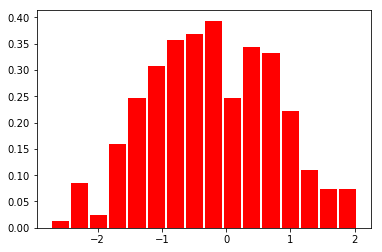

In [205]:
print('Sharpe Ratio Results (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_boll_aaa, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_boll_aaa))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


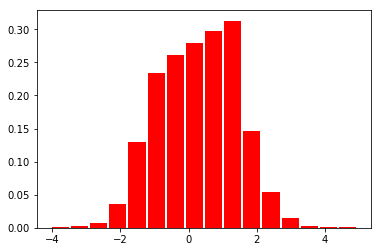

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))